<a href="https://colab.research.google.com/github/EsterCim/MERW-on-networks/blob/main/Complex_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code to generate a 50x50 lattice of degree 4 with periodic boundary conditions and remove a fraction q of links.

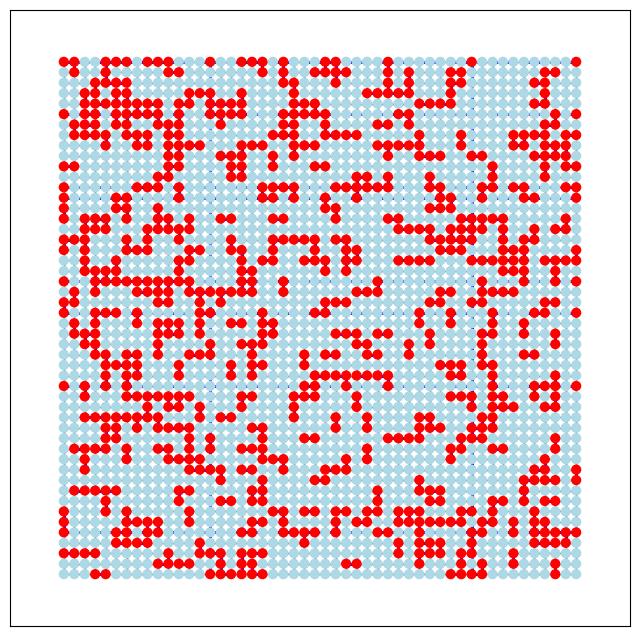

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(42)


rows, cols = 50, 50
q = 0.1 # fraction of edges to remove


G = nx.grid_2d_graph(rows, cols, periodic=True)
mapping = {(i, j): i * cols + j for i in range(rows) for j in range(cols)}
G = nx.relabel_nodes(G, mapping)

edges = list(G.edges())
num_remove = int(q * len(edges))
edges_to_remove = random.sample(edges, num_remove)
G.remove_edges_from(edges_to_remove)

# List the removed edges
#print("Removed edges:")
#for edge in edges_to_remove:
 #   print(edge)


node_color = ['red' if G.degree[n] < 4 else 'lightblue' for n in G.nodes()]


pos = {n: (n % cols, - (n // cols)) for n in G.nodes()}


remaining_edges = list(G.edges())
removed_edges_set = set(edges_to_remove)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=40)
nx.draw_networkx_edges(G, pos, edgelist=remaining_edges, edge_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=edges_to_remove, edge_color='blue', style='dashed', width=2)
#nx.draw_networkx_labels(G, pos, font_size=8)


#plt.title("")
plt.axis("equal")
plt.show()

Check to see if the graph is connected (A irreducible)

In [ ]:
import networkx as nx


if nx.is_connected(G):
    print("The graph is connected → adjacency matrix is irreducible.")
else:
    print("The graph is NOT connected → adjacency matrix is reducible.")


The graph is connected → adjacency matrix is irreducible.


Code to compute eigenvalues and eigenvectors of the adjacency matrix A of the above graph G, to select the largest eigenvalue with correspondant eigenvector and compute the square of each component. This to have the stationary distribution of a maximal entropy random walk on it.

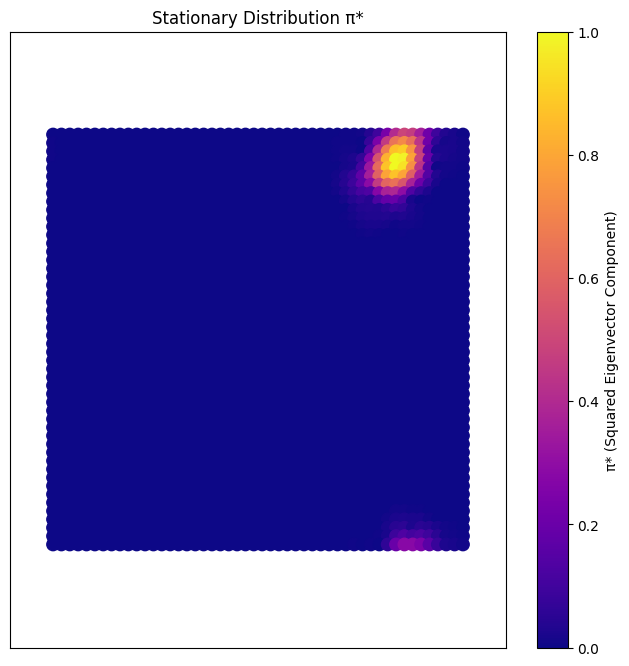

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse.linalg import eigs
from scipy.sparse import csr_matrix


A_sparse = nx.to_scipy_sparse_array(G, format='csr', dtype=float)


eigval, eigvec = eigs(A_sparse, k=1, which='LR')
v = np.real(eigvec[:, 0])
v = np.abs(v)
v /= np.linalg.norm(v)


v_squared = v ** 2
v_squared_norm = (v_squared - np.min(v_squared)) / (np.max(v_squared) - np.min(v_squared))


pos = {n: (n % cols, - (n // cols)) for n in G.nodes()}

ì
plt.figure(figsize=(8, 8))
nodes = nx.draw_networkx_nodes(G, pos, node_color=v_squared_norm, cmap='plasma', node_size=80)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1)
plt.title("Stationary Distribution π*")
plt.axis('equal')
plt.colorbar(nodes, label='π* (Squared Eigenvector Component)')
plt.show()